In [2]:
# Importing necessary libraries 
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pylab as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import classification_report

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


We start by importing the dataset and Transform categorical values into numerical values using one hot encoding. We clean the dataset and perform EDA on it for additional Feature Engineering to check the correlation between features and drop those features that have a strong correlation.

Training dataframe:
       credit.policy             purpose  int.rate  installment  \
0                 1  debt_consolidation    0.1189       829.10   
1                 1         credit_card    0.1071       228.22   
2                 1  debt_consolidation    0.1357       366.86   
3                 1  debt_consolidation    0.1008       162.34   
4                 1         credit_card    0.1426       102.92   
...             ...                 ...       ...          ...   
9573              0           all_other    0.1461       344.76   
9574              0           all_other    0.1253       257.70   
9575              0  debt_consolidation    0.1071        97.81   
9576              0    home_improvement    0.1600       351.58   
9577              0  debt_consolidation    0.1392       853.43   

      log.annual.inc    dti  fico  days.with.cr.line  revol.bal  revol.util  \
0          11.350407  19.48   737        5639.958333      28854        52.1   
1          11.082143  14.29 

<>:20: SyntaxWarning: invalid escape sequence '\A'
<>:20: SyntaxWarning: invalid escape sequence '\A'
/tmp/ipykernel_662075/3492240697.py:20: SyntaxWarning: invalid escape sequence '\A'
  print('Columns with N\A values:')


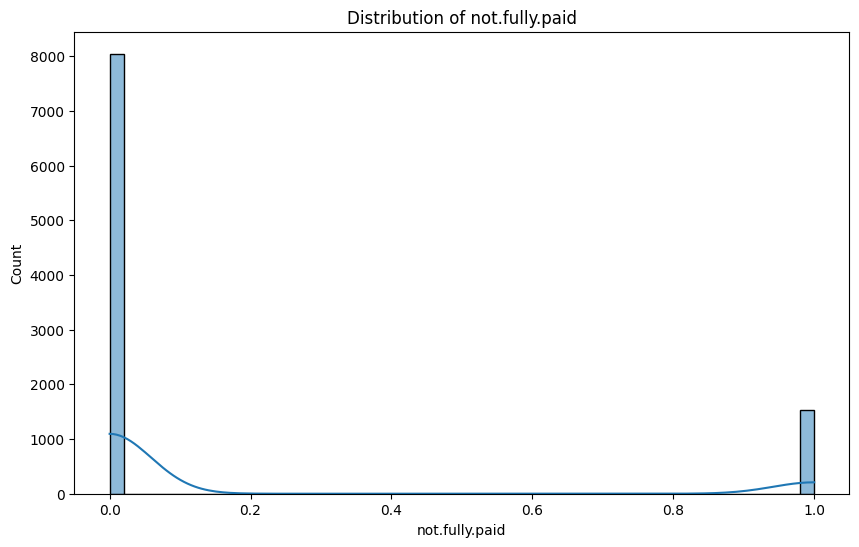

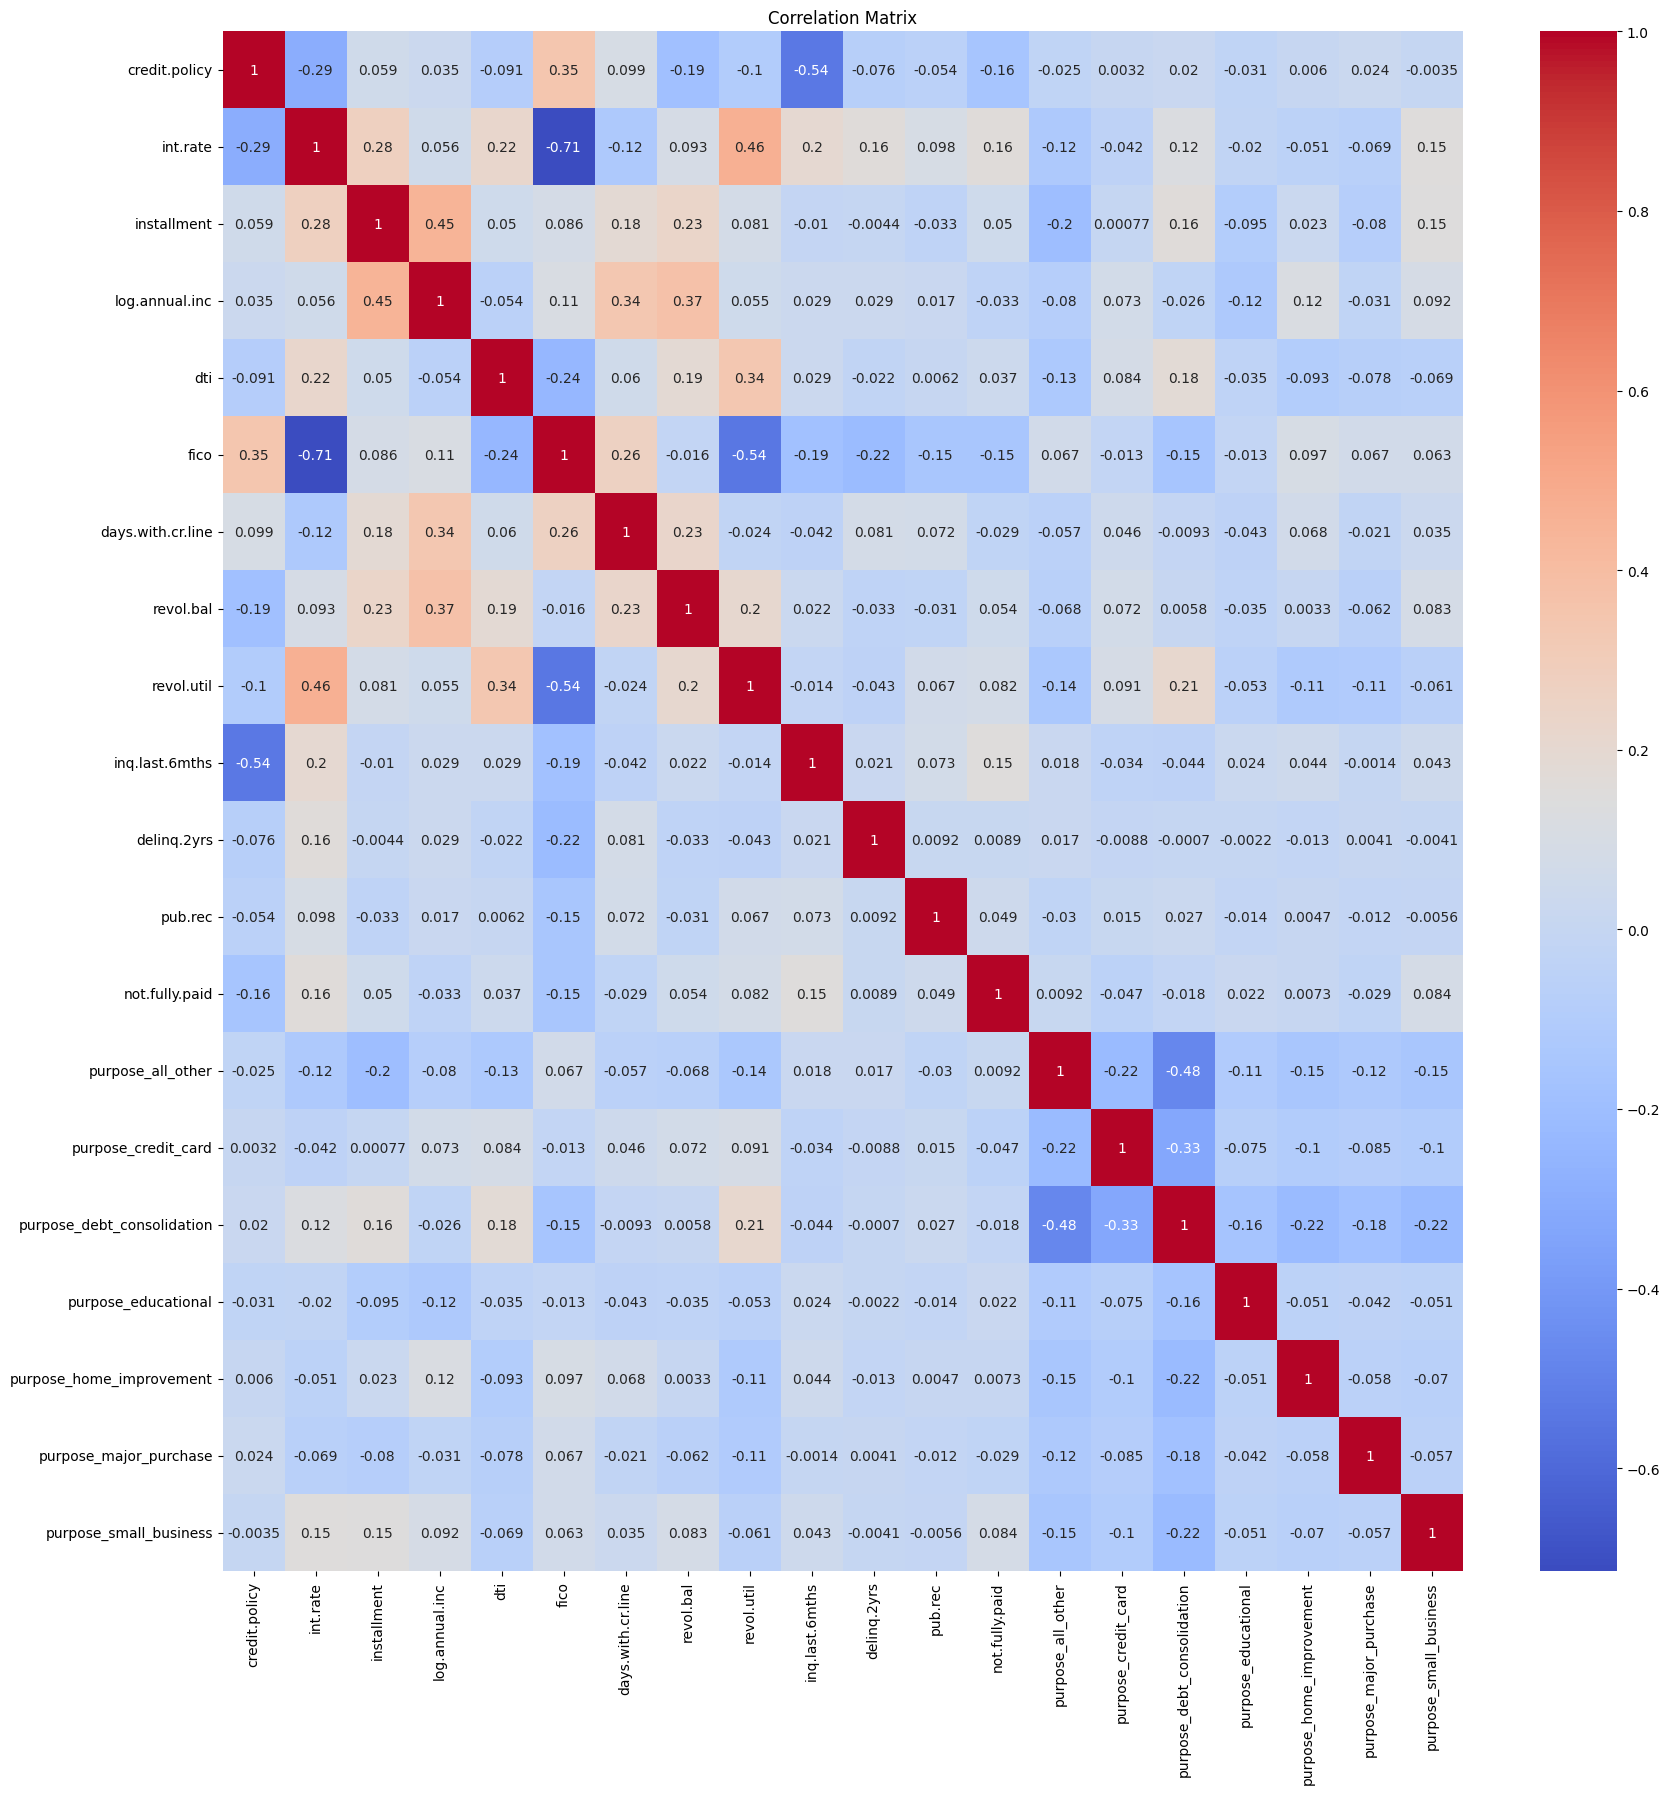

Highly correlated features: []


In [3]:
# importing the data files using pandas.read_csv reads the csv file 
rawIdata = pd.read_csv('loan_data.csv') # training dataset
print('Training dataframe:\n',rawIdata)

# Analyzing Stateholiday column 
unique_values = rawIdata['purpose'].unique()
print('Unique values of purpose\n',unique_values)

# One-Hot Encoding of StateHoliday
encoder = OneHotEncoder(sparse_output=False)
OHE = encoder.fit_transform(rawIdata[['purpose']])
encoded_features = pd.DataFrame(OHE, columns=encoder.get_feature_names_out(['purpose']))
rawIdata.drop(labels=['purpose'], axis=1, inplace=True)
rawIdata = pd.concat([rawIdata, encoded_features], axis=1)
print(rawIdata)

#Check for missing, null and duplicate values 
print('Columns with Null values:')
print(rawIdata.isnull().sum())
print('Columns with N\A values:')
print(rawIdata.isna().sum())
print('Columns with duplicated values:')
print(rawIdata.duplicated().sum())

#  Clean the data by removing or correcting any errors
rawIdata.drop_duplicates(inplace=True)
rawIdata.dropna(inplace=True)

# Exploratory Data Analysis (EDA)
# Plot the distribution of Sales
plt.figure(figsize=(10,6))
sns.histplot(rawIdata['not.fully.paid'], bins=50, kde=True)
plt.title("Distribution of not.fully.paid")
plt.show()

# Correlation heatmap to visualize the correlation between features
plt.figure(figsize=(20,20))
sns.heatmap(rawIdata.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

# Identify highly correlated features
threshold = 0.9
corr_matrix = rawIdata.corr()
high_corr_var = np.where(np.abs(corr_matrix) > threshold)
high_corr_var = [(corr_matrix.columns[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_var) if x != y and x < y]

if high_corr_var == '':
    print('N0 Highly correlated features')
else:
    print("Highly correlated features:", high_corr_var)



Next we check the distribution of the classes in the dataset and found the dataset to be highly imbalanced so we perform SMOTE on it.

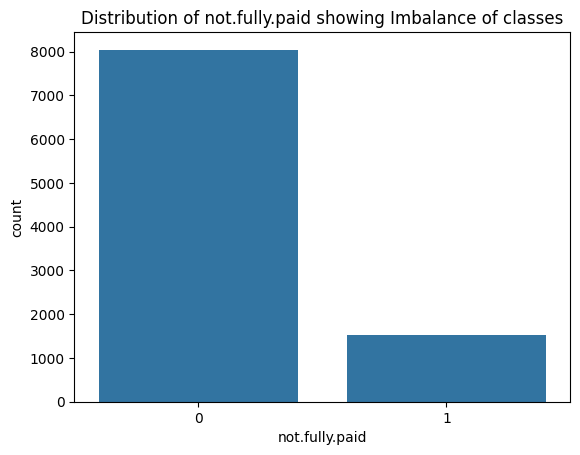

Shape of the new over-sampled dataset for features : (12872, 19) and target: (12872,)
Original dataset shape Counter({0: 6436, 1: 1226})
Resampled dataset shape Counter({0: 6436, 1: 6436})


In [4]:

# Distribution of sentiment classes for training dataset
sns.countplot(x='not.fully.paid', data=rawIdata)
plt.title('Distribution of not.fully.paid showing Imbalance of classes')
plt.show()

# Prepare data
X = rawIdata.drop('not.fully.paid', axis=1)
y = rawIdata['not.fully.paid']

# Create training and test sets
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Since the target variable is imbalanced for minorities, we can use SMOTE to balance the target variable
# Applying Oversampling on training dataset to balance the target variable using SMOTE
# SMOTE method applies SMOTE to oversample the minority calss with synthetic new data 
SN = SMOTE() # using SMOTE to create an object nm3
x_samples,y_samples= SN.fit_resample(X_train, y_train)    # fit and transform the training data
print('Shape of the new over-sampled dataset for features :'  , x_samples.shape, 'and target:',y_samples.shape)     # print the shape of the new dataset
print('Original dataset shape {}'.format(Counter(y_train)))
print('Resampled dataset shape {}'.format(Counter(y_samples)))


We perform standard scaler standardization on input dataset and create a deep learning model that will predict the not.fully.paid. We will evaluate the model on the testing that using accuracy score, f1 score from classification report and confusion matrix.

/home/rynem8/anaconda3/envs/py312/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1724792837.842658  662075 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724792837.842732  662075 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724792837.842746  662075 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724792838.292978  662075 cuda_executor.

Epoch 1/100


I0000 00:00:1724792839.842364  662268 service.cc:146] XLA service 0x7f298c00b4d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724792839.842426  662268 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2024-08-27 22:07:19.865111: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-27 22:07:20.006892: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


127/322 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5440 - loss: 0.8063

I0000 00:00:1724792841.207293  662268 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


322/322 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.5656 - loss: 0.7590 - val_accuracy: 0.0117 - val_loss: 0.8041
Epoch 2/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6290 - loss: 0.6398 - val_accuracy: 0.2427 - val_loss: 0.7791
Epoch 3/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6540 - loss: 0.6204 - val_accuracy: 0.4641 - val_loss: 0.7460
Epoch 4/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6725 - loss: 0.6036 - val_accuracy: 0.5184 - val_loss: 0.7425
Epoch 5/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6834 - loss: 0.6024 - val_accuracy: 0.5305 - val_loss: 0.7484
Epoch 6/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6866 - loss: 0.5954 - val_accuracy: 0.5433 - val_loss: 0.7015
Epoch 7/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7060 - loss: 0.5861 - val_accuracy: 0.5305 - val_loss: 0.6829
Epoch 8/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7031 - loss: 0.5864 - val_accuracy: 0.5421

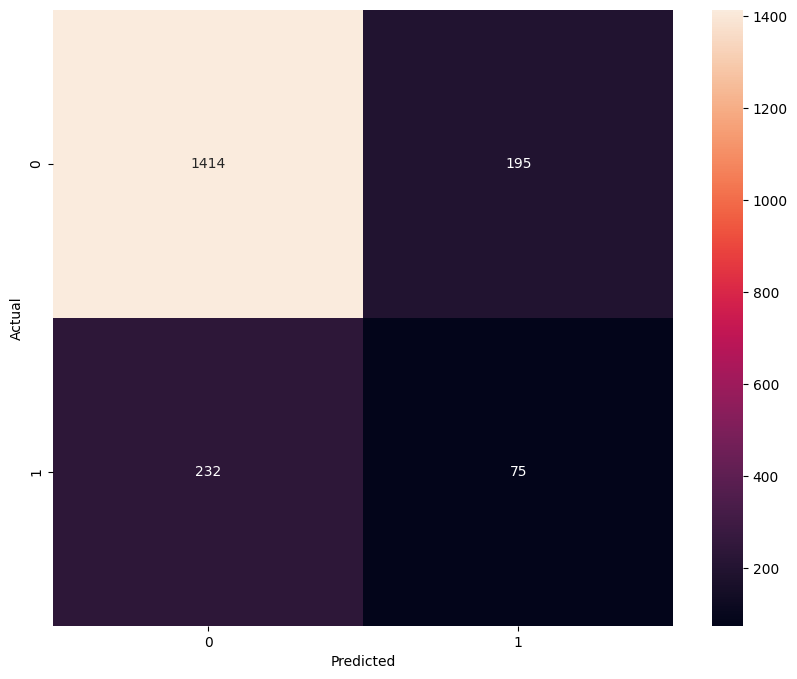

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      1609
           1       0.28      0.24      0.26       307

    accuracy                           0.78      1916
   macro avg       0.57      0.56      0.56      1916
weighted avg       0.77      0.78      0.77      1916



In [5]:
# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
# Scale features
scaler = StandardScaler()
x_samples = scaler.fit_transform(x_samples)
X_test = scaler.transform(X_test)

# Build the deep learning model
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(x_samples.shape[1],)))
model.add(Dropout(0.7))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Define the early stopping callback
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=50, restore_best_weights=True, verbose=1, mode='min')
sample_weights = compute_sample_weight(class_weight="balanced", y=y_samples)

# Train the model with class weights
history = model.fit(x_samples, y_samples, epochs=100, batch_size=32, validation_split=0.2, sample_weight=sample_weights, callbacks=es)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy*100:.4f}')

# Confusion matrix 
# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)
cm = tf.math.confusion_matrix(y_test, y_pred_classes) 
    
# Plotting the confusion matrix 
plt.figure(figsize=(10, 8)) 
sns.heatmap(cm, annot=True, fmt='g') 
plt.xlabel('Predicted') 
plt.ylabel('Actual') 
plt.show()

report = classification_report(y_test, y_pred_classes) 
print(report)